# Finetuning Models

Here we will construct a pipeline to efficiently make experiments and finetune pretrained models for volumes of data (3D inputs).

In [1]:
import os

base_path_dicom = f"{os.environ['RSNA_IAD_DATA_DIR']}"
series_path_dicom = f"{base_path_dicom}/series"

base_path_nifti = f"{os.environ['RSNA_IAD_DATA_DIR']}/nifti_data"
series_path_nifti = f"{base_path_nifti}/series"

In [2]:
import polars as pl

df = pl.read_csv(f"{base_path_dicom}/train.csv")
display(df.head(2))

LOCATION_LABELS_COLNAME = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
]

LABELS_COLNAME =  LOCATION_LABELS_COLNAME + ['Aneurysm Present']

SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.1000…",64,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.1000…",76,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
import nibabel
import torch

def nifti_load(series_base_path, serie_uid):
    nifti = nibabel.load(f"{series_base_path}/{serie_uid}.nii.gz")
    return nifti

def nifti_process(nifti):
    volume = torch.from_numpy(nifti.get_fdata()).to(torch.float32)
    metadata = nifti.header
    return volume, metadata 

def nifti_get_spacing(metadata):
    return torch.tensor(nifti.header.get_zooms())

In [ ]:
serie_uid = df["SeriesInstanceUID"][0]
nifti = nifti_load(series_path_nifti, serie_uid)
volume, nifti_metadata = nifti_process(nifti)

In [ ]:
print(volume.shape)
print(nifti_get_spacing(nifti_metadata))

In [6]:
import torch.nn.functional as F

class NormalizeSpacing:

    def __init__(self, interp_mode, domain_spacings_dict, get_metadata):
        self.interp_mode = interp_mode
        self.domain_spacings_dict = domain_spacings_dict
        self.get_metadata = get_metadata        

    def transform(self, volume, domain, spacing):

        assert volume.dtype == torch.float32, \
        "Pixel array data has to be of type torch.float32."
        assert len(volume.shape) == 5, \
        "Volume array must have 5 dimensions, i.e. (batch_size, channel_count, z, y, x)"
                
        domain_spacing = torch.tensor(self.domain_spacings_dict[domain])
        target_size = (torch.tensor(volume.shape[2:], dtype=torch.float32) / spacing * domain_spacing).to(torch.int32)
        volume = F.interpolate(volume, size=tuple(target_size), mode=self.interp_mode)
    
        return volume

In [7]:
class NormalizeSizeInterp:

    get_metadata = None
    
    def __init__(self, target_size, mode):
        self.target_size = target_size
        self.mode = mode    

    def transform(self, volume):
    
        assert volume.dtype == torch.float32, \
        "Pixel array data has to be of type torch.float32"
        
        volume = F.interpolate(volume, size=self.target_size, mode=self.mode)
        return volume

In [8]:
import numpy as np

class PercentileCropIntensity:

    get_metadata = None

    def __init__(self, percentiles):
        self.percentiles = percentiles
    
    def transform(self, volume):
        percentiles = np.percentile(volume.flatten().detach().cpu().numpy(), self.percentiles)
        volume = torch.clamp(volume, min=percentiles[0], max=percentiles[1])
        return volume

In [9]:
class StandardizeIntensity:

    get_metadata = None
    
    def transform(self, volume):

        assert volume.dtype == torch.float32, \
        "Pixel array data has to be of type torch.float32"
    
        volume = (volume - volume.mean()) / volume.std()
        
        return volume

In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, path, series_uid_l, labels, transforms):
        self.path = path
        self.series_uid_l = series_uid_l
        self.labels = labels
        self.transforms = transforms

        self.n = len(self.series_uid_l)
    
    def __len__(self):
        return self.n

We will change the `NiftiDataset` class to store `torch.Tensor`s in `.pt` files, so the first epoch is slower, due to loading NifTI files and pre-processing the volumes, but subsequent epochs will load the processed volumes directly from the files:

In [11]:
class NiftiDataset(Dataset):

    def __init__(self, path, series_uid_l, labels, transforms, cache_path):
        super().__init__(path, series_uid_l, labels, transforms)
        self.cache_path = cache_path
        if not os.path.exists(self.cache_path):
            os.mkdir(self.cache_path)

    def __getitem__(self, idx):

        serie_uid = self.series_uid_l[idx]
        label = self.labels[idx]

        if os.path.exists(f"{self.cache_path}/{serie_uid}.pt"):
            volume = torch.load(f"{self.cache_path}/{serie_uid}.pt")
        else:
            nifti = nifti_load(self.path, serie_uid)
            volume, metadata = nifti_process(nifti)
            volume = volume.unsqueeze(0).unsqueeze(0)
    
            for transform in transforms:
                if transform.get_metadata is not None:
                    transform_metadata = transform.get_metadata(idx, metadata)
                    volume = transform.transform(volume, *transform_metadata)
                else:
                    volume = transform.transform(volume)

            torch.save(volume, f"{self.cache_path}/{serie_uid}.pt")

        return volume[0], label

In [12]:
import multiprocessing

class NiftiDataLoader:

    def __init__(self, path, series_uid_l, labels, unit_transforms,
                 shuffle, batch_size, pin_memory, num_workers, cache_path):
        dataset = NiftiDataset(path, series_uid_l, labels, unit_transforms, cache_path=cache_path)
        self.loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  shuffle=shuffle, pin_memory=pin_memory,
                                                  num_workers=num_workers)

    def __iter__(self):
        for volumes, labels in self.loader:
            yield volumes, labels

We need to split the data in train and validation. But doing that taking into account every label will result in stratification groups with only one sample, and we need at least two samples per group. So I took a simple approach of sequentially going through the labels' columns and assigning them a number. For each column, if the previous column corresponding row already has a number equal to 0 and there is a 1 at this column's row (indicating there is an aneurysm at that location), then we assign it the current column's index+1. With this we construct the "stratify" column, where 0 means no aneurysm, and 1..n means the location where there is an aneurysm (though there can be multiple location, this is not taked into account here).

>Note: this is not good, because later columns will not be as well represented as in the original dataset. I could have ordered the columns by number of samples with aneurysms at that location, and then used the apporach above. That would still have that effect but for the dominant classes, so it is not as bad I would say.

In [13]:
df = df.with_columns(stratify=0)

for i, label in enumerate(LOCATION_LABELS_COLNAME):
    df = df.with_columns(pl.when((pl.col(label) == 1) & (pl.col("stratify") == 0)).then(i+1).otherwise(pl.col("stratify")).alias("stratify"))

df.head(2)

SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,stratify
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32
"""1.2.826.0.1.3680043.8.498.1000…",64,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.1000…",76,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Train/Validation Split
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, train_size=0.75, random_state=0, stratify=df["stratify"], shuffle=True)

To sample the training set for faster experiments, I decided to get a similar number of samples for each value in the "stratify" column corresponding to an aneurysm, and then the number of samples with no aneurysms equal to the total amount of samples with aneurysms. 

>Note: The sampling already can have the effect of distribution shift between training and validation, and sampling the dataset to balance the number of samples for each class (essentially undersampling) can have that effect to. So this may not be a good practice.

In [78]:
# Sample df
n_per_class = int(0.05 * df_train.shape[0] / len(LOCATION_LABELS_COLNAME))

np.random.seed(0)
index = np.arange(df_train.shape[0])
np.random.shuffle(index)

df_train_shuffled = df_train[index]
aneurysm_sample_df = df_train_shuffled.filter(df_train_shuffled["stratify"] != 0).group_by("stratify").head(n_per_class)
no_aneurysm_sample_df = df_train_shuffled.filter(df_train_shuffled["stratify"] == 0).head(aneurysm_sample_df.shape[0])

df_train_sample = pl.concat((aneurysm_sample_df.drop("stratify"), no_aneurysm_sample_df.drop("stratify")))

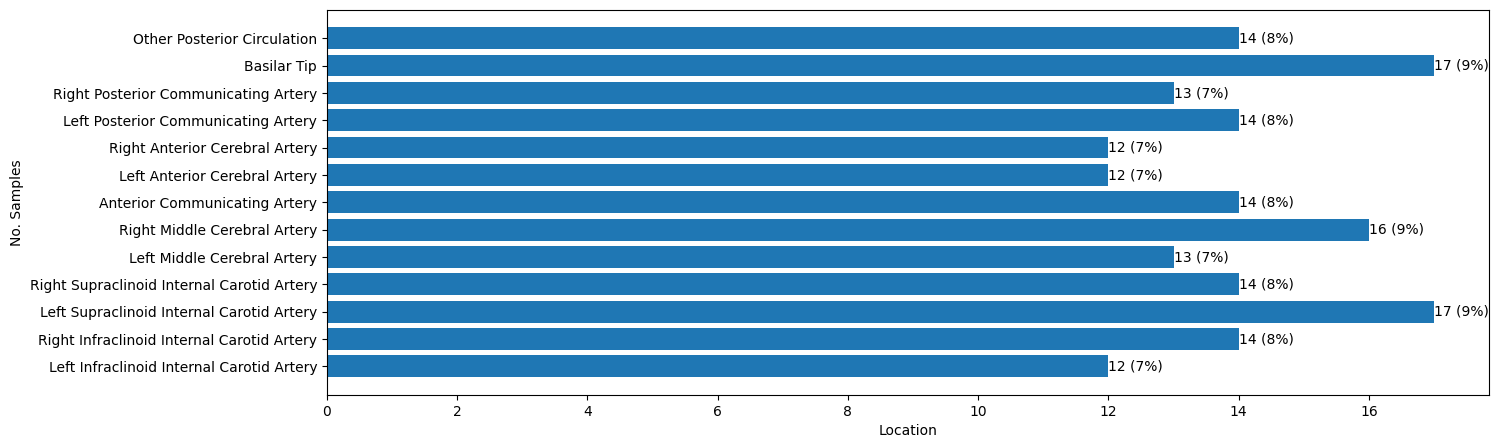

In [82]:
import matplotlib.pyplot as plt

def bar_plot(xs, ys, x_label, y_label, figsize, axis, horizontal):

    show_plot = False
    if axis is None:
        if len(plt.get_fignums()) > 0:
            axis = plt.gca()
        else:
            fig, axis = plt.subplots(figsize=figsize)
            show_plot = True
        
    if horizontal:
        bars = axis.barh(xs, ys)
    else:
        bars = axis.bar(xs, ys)

    total = ys.sum()
    axis.bar_label(bars, labels=[f"{y} ({round(y / total * 100)}%)" for y in ys])

    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    if show_plot is True:
        plt.show()

figsize=(15,5)

# No. samples with aneurysms of each type
n_aneurysms_by_location = df_train_sample[LOCATION_LABELS_COLNAME].sum()
bar_plot(n_aneurysms_by_location.columns, n_aneurysms_by_location.to_numpy()[0], "Location", "No. Samples", figsize, None, True)

Let's create a function that creates the `DataLoader`:

In [83]:
def loader_create(df):

    volume_domain_median_spacing_dict = {
        "CTA": (0.46875, 0.46875, 0.8),
        "MRA": (0.410156, 0.410156, 0.6),
        "MRI T1post": (0.5, 0.5, 1.2),
        "MRI T2": (0.5, 0.5, 5.)
    }

    def get_metadata_nifti(idx, metadata):
        modality = df["Modality"][idx]
        spacing = nifti_get_spacing(metadata)
        return modality, spacing

    transforms = [
        NormalizeSpacing("trilinear", volume_domain_median_spacing_dict, get_metadata_nifti),
        PercentileCropIntensity(percentiles=(0.5, 99.5)),
        StandardizeIntensity(), 
        NormalizeSizeInterp((32, 224, 224), "nearest")
    ]

    loader = NiftiDataLoader(series_path_nifti, 
                             list(df["SeriesInstanceUID"]), 
                             torch.from_numpy(df[LABELS_COLNAME].to_numpy()),
                             transforms, 
                             shuffle=True, batch_size=4, pin_memory=True, num_workers=4, 
                             cache_path=f"{base_path_nifti}/cache")
    
    return loader

We will use pretrained ResNets, trained on 23 different datasets of different organs. These are the result of the [Med3D study](
https://doi.org/10.48550/arXiv.1904.00625). Here i load the model from the [Warvito/MedicalNet-models](https://github.com/Warvito/MedicalNet-models) GitHub repository:

In [84]:
from torch import nn
from torch.nn import functional as F

class PretrainedMedResNet(nn.Module):

    out_channels = {
        "medicalnet_resnet10_23datasets": 512,
        "medicalnet_resnet50_23datasets": 2048,
    }
    
    def __init__(self, model_name, out_features):
        super().__init__()
        pretrained = torch.hub.load("Warvito/MedicalNet-models", model_name, trust_repo=True)
        pretrained.eval()
        self.pretrained = pretrained
        self.global_avg_pooling = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.linear = nn.Linear(self.out_channels[model_name], out_features, bias=False)
        self.linear.weight = nn.init.xavier_normal_(self.linear.weight)

    def forward(self, x):
        x = self.pretrained.forward(x)
        x = self.global_avg_pooling(x)
        x = x.squeeze(dim=(2,3,4))
        x = self.linear(x)
        if not self.training:  # training uses BCEWithLogitsLoss
            x = F.sigmoid(x)

        return x

So the pre-trained model is followed by a Global Average Pooling layer and then by a Fully Connected Linear Layer. The Global Average Pooling is to reduce the dimensionality of the model before applying the fully connected layer, making the latter simpler with the goal of preventing overfitting. The number of inputs to the final Linear Layers were obtained by looking at the number of channels returned by the last `BatchNormalization` layer in the ResNets.

The logits from the final Linear Layer are outputted as is during training, since we will be using Binary Cross Entroppy that takes the logits as inputs, which is more numerically stable.

In [85]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Here I write the finetuning function that takes a training and validation loader, for the training and validation sets, respectively, the model to finetune, the maximum number of epochs to train, and the path to store the model at. It takes the maximum number of epochs to train because it uses Early Stopping, meaning the training stops once the model stops improving its performance on the validation set. Here, we use 10 epochs of patience with a tolerance of 0.001, meaning the model has to improve more than 0.001 for the improvement to be considered, and if it does not improve for 10 epochs on the validation set, then training stops.

On the validation set we use the metric that will be used during the testing phase, which is the average of the Area Under the ROC curve for the samples with aneurym for each location, averaged with the same metric for the samples with any kind of aneurysm.

We apply a post processing to the prediction, so the last column which indicates if there is an aneurysm in any location is always in accordance with the others columns.

>Note: I forgot to save the model on the epoch were the performance stopped improving, and saved the one after the 10 patience epochs, which is incorrect.

In [86]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

def finetune(train_loader, val_loader, model, n_epochs_max, save_model_path):

    loss_f = nn.BCEWithLogitsLoss()

    lr = 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs_max)
    
    loss_l = []
    val_score_l = []
    best_val_score = None
    state_dict = None
    early_stopping_patience = 10
    early_stopping_patience_curr = 0
    
    for i in range(n_epochs_max):
        epoch_loss = 0

        # Train
        model = model.train()
        for volumes, labels in train_loader:
            volumes = volumes.to(device)
            labels = labels.to(torch.float32).to(device)

            # remove volumes with nan values
            invalid_volumes_mask = ~volumes.isnan().flatten(start_dim=1).any(dim=1)
            volumes = volumes[invalid_volumes_mask]
            labels = labels[invalid_volumes_mask]
            
            optimizer.zero_grad()
    
            scores = model.forward(volumes)
    
            if scores.isnan().sum() > 0:
                raise Exception("Corrupted model.")
            
            loss = loss_f(scores, labels)
            epoch_loss += loss.item()
    
            loss.backward()
            optimizer.step()
            scheduler.step()
    
        epoch_loss /= len(train_loader.loader)
        loss_l.append(epoch_loss)

        if not val_loader:
            print(f"Epoch {i}; Train Loss {epoch_loss}")
        else:
            # Validate
            model.eval()
            scores_l = []
            labels_l = []
            with torch.no_grad():
                for volumes, labels in val_loader:
                    volumes = volumes.to(device)
                    labels = labels.to(torch.float32).to(device)

                    volumes = volumes.nan_to_num() # fill missing values with 0.0
                    
                    scores = model.forward(volumes)
                    
                    if scores.isnan().sum() > 0:
                        raise Exception("Corrupted model.")
    
                    scores_l.append(scores)
                    labels_l.append(labels)
    
            scores_pt = torch.vstack(scores_l).detach().cpu().numpy()
            labels_pt = torch.vstack(labels_l).detach().cpu().numpy()
    
            # -- Predictions post-processing
            for j in range(scores_pt.shape[0]):
                if any(scores_pt[j, :-1] > 0.5):
                    scores_pt[j, -1] = 1.0
                else:
                    scores_pt[j, -1] = 0.0

            # -- Calculate validation metric
            roc_auc = roc_auc_score(labels_pt, scores_pt, average=None)
            val_score = (roc_auc[-1] + roc_auc[:-1].mean()) * 0.5
            val_score_l.append(val_score)
            
            print(f"Epoch {i}; Train Loss {epoch_loss}; Validation Score {val_score}")
    
            # Apply early stopping
            if (best_val_score is None) or (val_score > (best_val_score + 0.001)):
                state_dict = model.state_dict()
                best_val_score = val_score
                early_stopping_patience_curr = 0
            else:
                early_stopping_patience_curr += 1
                if early_stopping_patience_curr == early_stopping_patience:
                    if save_model_path is not None:
                        torch.save(state_dict, save_model_path)
                    return loss_l, val_score_l

    if save_model_path is not None:
        torch.save(state_dict, save_model_path)
    
    return loss_l, val_score_l

In [87]:
loader_sample = loader_create(df_train_sample)
loader_val = loader_create(df_val)

model_resnet10 = PretrainedMedResNet("medicalnet_resnet10_23datasets", 14)
model_resnet10 = model_resnet10.to(device)

loss_l, val_score_l = finetune(loader_sample, loader_val, model_resnet10, 120, "/workspace/resnet10.pth")

Using cache found in /root/.cache/torch/hub/Warvito_MedicalNet-models_main


Epoch 0; Train Loss 0.38576351258999264; Validation Score 0.5152544162423518
Epoch 1; Train Loss 0.23375082054199317; Validation Score 0.5183115452944622
Epoch 2; Train Loss 0.22658706169862014; Validation Score 0.5387688290366439
Epoch 3; Train Loss 0.2198004488570568; Validation Score 0.5398660311088936
Epoch 4; Train Loss 0.2141556930847657; Validation Score 0.5390222271918255
Epoch 5; Train Loss 0.21522743264452004; Validation Score 0.5362559207798951
Epoch 6; Train Loss 0.21670041624934244; Validation Score 0.536610406780897
Epoch 7; Train Loss 0.20878388598943368; Validation Score 0.5390496594943626
Epoch 8; Train Loss 0.2124464378142968; Validation Score 0.5376525417399929
Epoch 9; Train Loss 0.2108205367739384; Validation Score 0.5383124933024467
Epoch 10; Train Loss 0.20531981610334837; Validation Score 0.5390761203745071
Epoch 11; Train Loss 0.20395114349249083; Validation Score 0.5206522333859094
Epoch 12; Train Loss 0.21289848345212448; Validation Score 0.5416855387261197
E

We use the lighter model (ResNet10) to train on the sample training set.

We can verify that the performance improved, but not much (from 0.515 to 0.547).

Now on the whole training set with the heavier model (ResNet50):

In [57]:
loader_train = loader_create(df_train)
loader_val = loader_create(df_val)

model_resnet50 = PretrainedMedResNet("medicalnet_resnet50_23datasets", 14)
model_resnet50 = model_resnet50.to(device)

loss_l, val_score_l = finetune(loader_train, loader_val, model_resnet50, 120, "/workspace/resnet50_train_val.pth")

Using cache found in /root/.cache/torch/hub/Warvito_MedicalNet-models_main


Epoch 0; Train Loss 0.2019424137303277; Validation Score 0.5232832566089449
Epoch 1; Train Loss 0.1945348786619291; Validation Score 0.5232502145180512
Epoch 2; Train Loss 0.1945469601664181; Validation Score 0.5300774271283897
Epoch 3; Train Loss 0.19386267787594275; Validation Score 0.5395614672163476
Epoch 4; Train Loss 0.1924308969036621; Validation Score 0.5399839491319558
Epoch 5; Train Loss 0.19254090396376947; Validation Score 0.540975810619104
Epoch 6; Train Loss 0.19163510653044225; Validation Score 0.5423311220076471
Epoch 7; Train Loss 0.19162775461525455; Validation Score 0.5504449433702849
Epoch 8; Train Loss 0.19066904374288723; Validation Score 0.5558149275713012
Epoch 9; Train Loss 0.1905277721656888; Validation Score 0.5482644704608037
Epoch 10; Train Loss 0.1902269991982144; Validation Score 0.5589457030406708
Epoch 11; Train Loss 0.18933469080822726; Validation Score 0.5611364264734483
Epoch 12; Train Loss 0.1892153338492647; Validation Score 0.5525392633756667
Epoc

Here the performance improved a little more, but also not much (from 0.523 to 0.564).

Now let's train the heavier model on the whole set, without early stopping:

In [ ]:
loader_df = loader_create(df)

model_resnet50 = PretrainedMedResNet("medicalnet_resnet50_23datasets", 14)
model_resnet50 = model_resnet50.to(device)

loss_l, val_score_l = finetune(loader_df, None, model_resnet50, 120, "/workspace/resnet50_complete.pth")

In [94]:
loss_l[25]

0.18168805725358447

In [103]:
volume_domain_median_spacing_dict = {
    "CTA": (0.46875, 0.46875, 0.8),
    "MRA": (0.410156, 0.410156, 0.6),
    "MRI T1post": (0.5, 0.5, 1.2),
    "MRI T2": (0.5, 0.5, 5.)
}

def get_metadata_nifti(idx, metadata):
    modality = df["Modality"][idx]
    spacing = nifti_get_spacing(metadata)
    return modality, spacing

transforms = [
    NormalizeSpacing("trilinear", volume_domain_median_spacing_dict, get_metadata_nifti),
    PercentileCropIntensity(percentiles=(0.5, 99.5)),
    StandardizeIntensity(), 
    NormalizeSizeInterp((32, 224, 224), "nearest")
]

nifti = nifti_load(series_path)
volume, metadata = nifti_process(nifti)
volume = volume.unsqueeze(0).unsqueeze(0)

for transform in transforms:
    if transform.get_metadata is not None:
        transform_metadata = transform.get_metadata(idx, metadata)
        volume = transform.transform(volume, *transform_metadata)
    else:
        volume = transform.transform(volume)

model_resnet50 = PretrainedMedResNet("medicalnet_resnet50_23datasets", 14)
model_resnet50 = model_resnet50.to(device)

# Predict
scores_l = []
labels_l = []
with torch.no_grad():
    model_resnet50 = model_resnet50.eval()

    for volumes, labels in loader:
        volumes = volumes.to(device)
        labels = labels.to(device)
        volumes = volumes.nan_to_num()
        
        scores = model_resnet50.forward(volumes)
        scores_l.append(scores)
        labels_l.append(labels)
    
scores_arr = torch.vstack(scores_l).detach().cpu().numpy()
labels_arr = torch.vstack(labels_l).to(torch.float32).detach().cpu().numpy()

# Post-processing
has_aneurysm_preds_mask = (scores_arr[:, :-1] > 0.5).any(axis=1)
scores_arr[has_aneurysm_preds_mask, -1] = 1.0
scores_arr[~has_aneurysm_preds_mask, -1] = 0.0

roc_auc_scores = roc_auc_score(labels_arr, scores_arr, average=None)
final_score = (np.mean(roc_auc_scores[:-1]) + roc_auc_scores[-1]) * 0.5
print(final_score)

0.9939361642679363


Here the model completely overfitted the training data, which means it should be complex enough to capture the patterns in the medical imaging volumes, given that the training data is representative of the population data. But we cannot use this model for inference, since the performance on the test data would be really bad.

In [123]:
with torch.no_grad():
    volume, label = next(iter(loader))
    
    volume = volume.to(device)
    label = label.to(device)
    volume = volume.nan_to_num()
    
    scores = model_resnet50.forward(volume)

In [124]:
if (scores[:, :-1] > 0.5).any().item():
    scores[:, -1] = 1.0
else:
    scores[:, -1] = 0.0

In [125]:
scores

tensor([[2.5632e-05, 1.6649e-06, 2.3504e-03, 3.8969e-05, 1.5284e-02, 9.7983e-01,
         1.3989e-06, 9.8677e-01, 3.5252e-04, 9.9944e-01, 1.5912e-03, 2.0041e-03,
         7.7659e-08, 1.0000e+00]], device='cuda:0')